In [13]:
import os
import joblib
import numpy   as np
import seaborn as sns
import pandas  as pd

from typing import Dict

# Machine learning methods
from sklearn            import tree
from sklearn.tree       import plot_tree
from sklearn.tree       import export_text
from sklearn.tree       import DecisionTreeClassifier
from sklearn.metrics    import accuracy_score
from sklearn.metrics    import confusion_matrix
from sklearn.metrics    import classification_report
from sklearn.metrics    import f1_score

from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor

# Plotting utilities
import matplotlib.pyplot as plt

# Import formatter
from matplotlib.ticker import FuncFormatter

In [14]:
# Constants
N = 25
K = 20

VALUES = [0, 1, 2, 3]
LABELS = ["LD", "SD", "HD", "FULL-HD"]
COLORS = ["black", "red", "green", "blue"]

# Define the name of the new columns
NUMBER          = "id"
CLASS           = "class"
PREDICTED_CLASS = "predicted_class"
TESTBED_RATE    = "testbed_rate"
AVG_VIDEO_RATE  = "avg_video_rate"

In [15]:
def get_video_class(kbits: float) -> int:
    if 0 <= kbits <= 288:
        return 0  # LD
    elif 289 <= kbits <= 1500:
        return 1  # SD
    elif 1501 <= kbits <= 6500:
        return 2  # HD
    elif 6501 <= kbits <= 8000:
        return 3  # FULL-HD
    
def format_bytes(num_bytes: float) -> str:
    units = ['B', 'KB', 'MB', 'GB', 'TB']
    size  = float(num_bytes)

    for unit in units:
        if size < 1024:
            return f"{size:.2f} {unit}"
        size /= 1024
    return f"{size:.2f} {units[-1]}"

In [16]:
# Define directories
dir = os.path.join(os.path.dirname(os.getcwd()), "udp")

In [17]:
# Define the rate of the experiments
rates = ["1500kbits", "3000kbits", "4500kbits", "6000kbits", "7500kbits", "50000kbits"]

In [18]:
# Define dictionary for staging data
data : Dict[str, list[str]] = {}

In [19]:
# For each rate, get N samples
for rate in rates:
    files = [os.path.join(dir, rate, file) for file in os.listdir(os.path.join(dir, rate))]
    data[rate] = files[0:N]

In [20]:
# For each rate, create training set and testing set
tg_set = []
ts_set = []

In [21]:
for rate in rates:
    # Generate the training set
    for sample in data[rate][0:K]:
        frame = pd.read_csv(sample, sep=" ")
        frame[CLASS] = frame[AVG_VIDEO_RATE].apply(get_video_class)
        tg_set.append(frame)
        
    # Generate the testing set
    for sample in data[rate][K:N]:
        frame = pd.read_csv(sample, sep=" ")
        frame[CLASS] = frame[AVG_VIDEO_RATE].apply(get_video_class)
        ts_set.append(frame)
        
print(f"[TRAINING SET]: number of streaming periods = {len(tg_set)} over {len(rates)} bandwidth")
print(f"[TESTING  SET]: number of streaming periods = {len(ts_set)} over {len(rates)} bandwidth")

[TRAINING SET]: number of streaming periods = 120 over 6 bandwidth
[TESTING  SET]: number of streaming periods = 30 over 6 bandwidth


In [22]:
features = []
for i in range(0, 10):    
    # Volumetric metrics
    features.append(f"s_bytes_all_#{i}")
    features.append(f"c_bytes_all_#{i}")
    # features.append(f"s_ack_cnt_#{i}")
    # features.append(f"c_ack_cnt_#{i}")
    # features.append(f"s_ack_cnt_p_#{i}")
    # features.append(f"c_ack_cnt_p_#{i}")

    # Temporal metrics
    features.append(f"idle_#{i}")
    features.append(f"max_span_#{i}")
    features.append(f"min_span_#{i}")
    features.append(f"avg_span_#{i}")
    features.append(f"std_span_#{i}")

# Volumetric metrics (outer columns)
features.append(f"s_bytes_all")
features.append(f"c_bytes_all")
# features.append(f"s_ack_cnt")
# features.append(f"c_ack_cnt")
# features.append(f"s_ack_cnt_p")
# features.append(f"c_ack_cnt_p")

# Temporal metrics (outer columns)
features.append(f"idle")
features.append(f"max_span")
features.append(f"min_span")
features.append(f"avg_span")
features.append(f"std_span")

In [23]:
def grid_search_cv(i: int, periods: list[pd.DataFrame], configurations: list):
    results = []
    
    # Validation set
    testing = periods[i]
    
    x_test  = testing[features]
    y_test  = testing[CLASS]

    # Training set
    training = pd.concat([periods[j] for j in range(len(periods)) if j != i], ignore_index=True)
    x_train  = training[features]
    y_train  = training[CLASS]
    
    for configuration in configurations:
        random_state      = 10
        max_depth         = configuration["max_depth"]
        criterion         = configuration["criterion"]
        min_samples_leaf  = configuration["min_samples_leaf"]
        
        # Generate a model with the configuration
        model = DecisionTreeClassifier(random_state=random_state, max_depth=max_depth, criterion=criterion, min_samples_leaf=min_samples_leaf)

        # Train the model
        model.fit(x_train, y_train)
        
        # Generate the predictions
        preds = model.predict(x_test)

        # Compute the accuracy
        accuracy = accuracy_score(y_test, preds)
        
        # Compute F1-scores
        macro_f1 = f1_score(y_test, preds, average='macro')
        micro_f1 = f1_score(y_test, preds, average='micro')
        
        # Add the result to the list
        results.append((model, configuration, accuracy, macro_f1, micro_f1)) 
    
    return results

configurations = [
    {"min_samples_leaf": ns, "max_depth": nl, "criterion": gn}
    for ns in range(20, 301, 20)
    for nl in range(1,  5, 1)
    for gn in ["gini", "entropy"]
]

results = []
with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = [executor.submit(grid_search_cv, i, tg_set, configurations) for i in range(len(tg_set))]
    for future in futures:
        results.extend(future.result())

In [ ]:
scores = defaultdict(lambda: {
    "accuracy_scores":  [],
    "macro_f1_scores":  [],
    "micro_f1_scores":  [],
    "trained_models":   []
})

for model, configuration, accuracy, macro_f1, micro_f1 in results:
    key = tuple(configuration.items())
    scores[key]["accuracy_scores"].append(accuracy)
    scores[key]["macro_f1_scores"].append(macro_f1)
    scores[key]["micro_f1_scores"].append(micro_f1)
    scores[key]["trained_models"].append(model)
    
# Get the model that has the best macro-f1 over all k-fols in
# the average
best_model: DecisionTreeClassifier = None
best_confg: dict = None
best_accuracy = -1

for key, value in scores.items():
    accuracy = np.mean(value["accuracy_scores"])
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_confg    = dict(key)
        best_model    = value["trained_models"][np.argmax(value["accuracy_scores"])]
        
print(f"[BEST CONFIGURATION]")
for key, value in best_confg.items():
    print(f"KEY = {key}, VALUE = {value}")
    

# Directory to save the model
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save the best model to disk
model_path = os.path.join(save_dir, "udp_model.pkl")
joblib.dump(best_model, model_path)

[BEST CONFIGURATION]
KEY = min_samples_leaf, VALUE = 20
KEY = max_depth, VALUE = 4
KEY = criterion, VALUE = entropy


['saved_models/tcp_model.pkl']

In [25]:
tg_set_frame = pd.concat(tg_set, ignore_index=True)
ts_set_frame = pd.concat(ts_set, ignore_index=True)

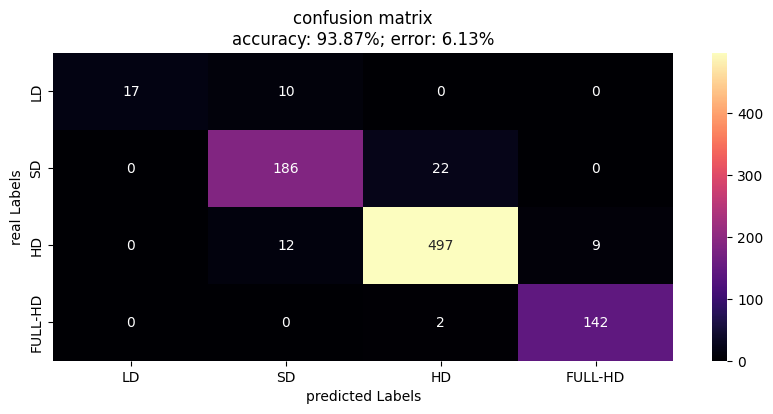

\[CLASSIFICATION REPORT]
              precision    recall  f1-score   support

          LD       1.00      0.63      0.77        27
          SD       0.89      0.89      0.89       208
          HD       0.95      0.96      0.96       518
     FULL-HD       0.94      0.99      0.96       144

    accuracy                           0.94       897
   macro avg       0.95      0.87      0.90       897
weighted avg       0.94      0.94      0.94       897

FEATURE              IMPORTANCE
----------------------------------------
s_bytes_all         : 0.6681
idle                : 0.3163
s_bytes_all_#5      : 0.0074
s_bytes_all_#3      : 0.0063
avg_span_#7         : 0.0019
s_bytes_all_#0      : 0.0000
c_bytes_all_#0      : 0.0000
idle_#0             : 0.0000
max_span_#0         : 0.0000
min_span_#0         : 0.0000
avg_span_#0         : 0.0000
std_span_#0         : 0.0000
s_bytes_all_#1      : 0.0000
c_bytes_all_#1      : 0.0000
idle_#1             : 0.0000
max_span_#1         : 0.0000
min

In [26]:
x_test  = ts_set_frame[features]
y_test  = ts_set_frame[CLASS]
    
# Test the model
preds = best_model.predict(x_test)
score = accuracy_score(y_test, preds)

classes              = best_model.classes_
features_importance  = list(best_model.feature_importances_)
features_names       = list(best_model.feature_names_in_)

# Compute the accuracy and the error rate
accuracy   = score
error_rate = 100 - accuracy * 100
accuracy   = accuracy * 100 

# Create confusion matrix
matrix = confusion_matrix(y_test, preds)

# Generate the plot
plt.figure(figsize=(10, 4))
sns.heatmap(matrix, 
            annot=True, fmt="d", cmap="magma", 
            xticklabels=[LABELS[i] for i in classes], 
            yticklabels=[LABELS[i] for i in classes])

# Render the plot
plt.xlabel("predicted Labels")
plt.ylabel("real Labels")
plt.title(f"confusion matrix\naccuracy: {accuracy:.2f}%; error: {error_rate:.2f}%")
plt.show()

print("\[CLASSIFICATION REPORT]")
print(classification_report(y_test, preds, target_names=[LABELS[i] for i in classes]))

# Print the feature importances
features = [(key, value) for key, value in zip(features_names, features_importance)]
summary  = sorted(features, key=lambda x: x[1], reverse=True)
print(f"{'FEATURE':<20} {'IMPORTANCE'}")
print("-" * 40)
for key, value in summary:
    print(f"{key:<20}: {value:.4f}")